## Import thư viện

In [83]:
!pip install torchsummary
!pip install datasets
from datasets import load_dataset
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import numpy as np
import json, os, math
from tqdm import tqdm

## Model

In [84]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [85]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [86]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

In [87]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


In [88]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [89]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


In [90]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [91]:
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)
     

## Cifar100

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

#Tiny ImageNet
# dataset = load_dataset('zh-plus/tiny-imagenet', cache_dir='./data/')
# trainset = dataset['train']
# testset = dataset['valid']
# classes = tuple(dataset['train'].features['label'].names)

#CIFAR100
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
classes= tuple(trainset.classes)

print(classes)

Files already downloaded and verified
Files already downloaded and verified
('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tracto

### Transform TinyImageNet

In [ ]:

# from torch.utils.data import Dataset
# import torch
# from PIL import Image
# import numpy as np

# class TinyImageNetDataset(Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.dataset)
    
#     def __getitem__(self, idx):
#         # Get image and label from the dataset
#         sample = self.dataset[idx]
#         image = sample['image']
#         label = sample['label']
        
#         # Convert to PIL Image if needed
#         if not isinstance(image, Image.Image):
#             image = Image.fromarray(np.uint8(image))
            
#         # Apply transforms if any
#         if self.transform:
#             image = self.transform(image)
            
#         return image, label

# # Create train and test datasets with the respective transforms
# trainset = TinyImageNetDataset(dataset['train'], transform=transform_train)
# testset = TinyImageNetDataset(dataset['valid'], transform=transform_test)

### Config

In [95]:
config = {
    "patch_size": 4, # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 128,  # representation capacity
    "num_hidden_layers": 6,  # transformer layers
    "num_attention_heads": 4,  # attention heads
    "intermediate_size": 4 * 128,  # Proportional # 4 * hidden_size
    "hidden_dropout_prob": 0.3,  # regularization
    "attention_probs_dropout_prob": 0.3,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100,
    "num_channels": 3,
    "qkv_bias": True,
}

In [96]:
def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, report, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
            'report': report,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    report = data['report']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile, weights_only=True))
    return config, model, train_losses, test_losses, accuracies, report


def visualize_images():
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True)
    classes = tuple(trainset.classes)
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

Files already downloaded and verified


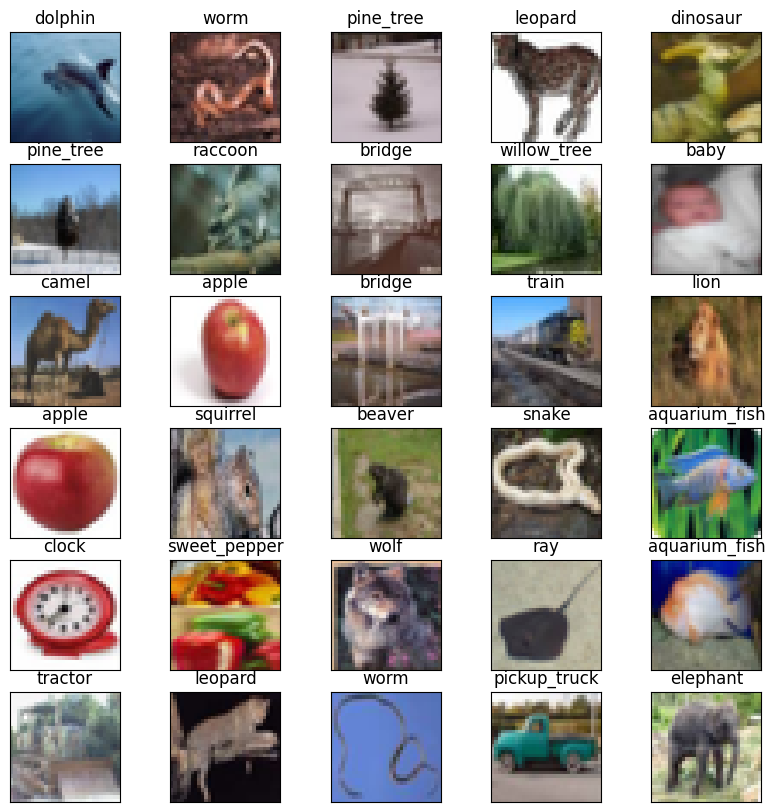

In [97]:
# Show some training images
visualize_images()

## Train, Test

In [112]:
exp_name = 'vit-with-100-epochs' #@param {type:"string"}
batch_size = 1024 #@param {type: "integer"}
epochs = 100 #@param {type: "integer"}
lr = 1e-4  #@param {type: "number"}
save_model_every = 20 #@param {type: "integer"}

class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, scheduler, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in tqdm(range(epochs)):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss, report = self.evaluate(testloader)
            scheduler.step(test_loss)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies, report)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        # Lists to store true labels and predictions
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()

                # Store labels and predictions for classification report
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                report = classification_report(all_labels, all_predictions, zero_division=0)
                
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss, report


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    # optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, scheduler, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()

  1%|          | 1/100 [00:41<1:08:27, 41.48s/it]

Epoch: 1, Train loss: 4.3137, Test loss: 4.1373, Accuracy: 0.0696


  2%|▏         | 2/100 [01:23<1:07:49, 41.53s/it]

Epoch: 2, Train loss: 4.0145, Test loss: 3.9396, Accuracy: 0.0903


  3%|▎         | 3/100 [02:04<1:07:19, 41.64s/it]

Epoch: 3, Train loss: 3.8213, Test loss: 3.7424, Accuracy: 0.1202


  4%|▍         | 4/100 [02:46<1:06:37, 41.64s/it]

Epoch: 4, Train loss: 3.6741, Test loss: 3.6180, Accuracy: 0.1421


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 5, Train loss: 3.5556, Test loss: 3.5544, Accuracy: 0.1475


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 6, Train loss: 3.4472, Test loss: 3.3848, Accuracy: 0.1786


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 7, Train loss: 3.3531, Test loss: 3.2784, Accuracy: 0.1940


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e3ed6c11f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 8, Train loss: 3.2528, Test loss: 3.1985, Accuracy: 0.2147


  9%|▉         | 9/100 [06:15<1:03:19, 41.75s/it]

Epoch: 9, Train loss: 3.1721, Test loss: 3.2505, Accuracy: 0.2068


 10%|█         | 10/100 [06:57<1:02:33, 41.70s/it]

Epoch: 10, Train loss: 3.1096, Test loss: 3.0564, Accuracy: 0.2385


 11%|█         | 11/100 [07:38<1:01:48, 41.67s/it]

Epoch: 11, Train loss: 3.0515, Test loss: 3.0260, Accuracy: 0.2469


 12%|█▏        | 12/100 [08:20<1:01:08, 41.69s/it]

Epoch: 12, Train loss: 2.9956, Test loss: 3.0165, Accuracy: 0.2538


 13%|█▎        | 13/100 [09:02<1:00:25, 41.67s/it]

Epoch: 13, Train loss: 2.9495, Test loss: 2.9263, Accuracy: 0.2665


 14%|█▍        | 14/100 [09:43<59:41, 41.65s/it]  

Epoch: 14, Train loss: 2.9017, Test loss: 2.8857, Accuracy: 0.2755


 15%|█▌        | 15/100 [10:25<58:58, 41.63s/it]

Epoch: 15, Train loss: 2.8622, Test loss: 2.9101, Accuracy: 0.2733


 16%|█▌        | 16/100 [11:07<58:23, 41.71s/it]

Epoch: 16, Train loss: 2.8145, Test loss: 2.8612, Accuracy: 0.2813


 17%|█▋        | 17/100 [11:48<57:39, 41.68s/it]

Epoch: 17, Train loss: 2.7868, Test loss: 2.8188, Accuracy: 0.2915


 18%|█▊        | 18/100 [12:30<56:55, 41.66s/it]

Epoch: 18, Train loss: 2.7474, Test loss: 2.6964, Accuracy: 0.3140


 19%|█▉        | 19/100 [13:11<56:12, 41.63s/it]

Epoch: 19, Train loss: 2.7080, Test loss: 2.6625, Accuracy: 0.3205


 20%|██        | 20/100 [13:53<55:31, 41.64s/it]

Epoch: 20, Train loss: 2.6752, Test loss: 2.6488, Accuracy: 0.3199
	Save checkpoint at epoch 20


 21%|██        | 21/100 [14:35<54:50, 41.65s/it]

Epoch: 21, Train loss: 2.6462, Test loss: 2.6701, Accuracy: 0.3133


 22%|██▏       | 22/100 [15:16<54:08, 41.64s/it]

Epoch: 22, Train loss: 2.6136, Test loss: 2.5653, Accuracy: 0.3343


 23%|██▎       | 23/100 [15:58<53:25, 41.63s/it]

Epoch: 23, Train loss: 2.5795, Test loss: 2.6044, Accuracy: 0.3298


 24%|██▍       | 24/100 [16:40<52:42, 41.61s/it]

Epoch: 24, Train loss: 2.5504, Test loss: 2.5275, Accuracy: 0.3413


 25%|██▌       | 25/100 [17:21<52:01, 41.62s/it]

Epoch: 25, Train loss: 2.5218, Test loss: 2.5113, Accuracy: 0.3456


 26%|██▌       | 26/100 [18:03<51:20, 41.63s/it]

Epoch: 26, Train loss: 2.4984, Test loss: 2.4915, Accuracy: 0.3529


 27%|██▋       | 27/100 [18:44<50:38, 41.62s/it]

Epoch: 27, Train loss: 2.4664, Test loss: 2.4345, Accuracy: 0.3592


 28%|██▊       | 28/100 [19:26<49:56, 41.62s/it]

Epoch: 28, Train loss: 2.4443, Test loss: 2.4373, Accuracy: 0.3598


 29%|██▉       | 29/100 [20:08<49:13, 41.60s/it]

Epoch: 29, Train loss: 2.4191, Test loss: 2.3977, Accuracy: 0.3722


 30%|███       | 30/100 [20:49<48:31, 41.59s/it]

Epoch: 30, Train loss: 2.3911, Test loss: 2.4071, Accuracy: 0.3726


 31%|███       | 31/100 [21:31<47:50, 41.61s/it]

Epoch: 31, Train loss: 2.3668, Test loss: 2.3687, Accuracy: 0.3768


 32%|███▏      | 32/100 [22:12<47:09, 41.61s/it]

Epoch: 32, Train loss: 2.3431, Test loss: 2.3535, Accuracy: 0.3801


 33%|███▎      | 33/100 [22:54<46:29, 41.64s/it]

Epoch: 33, Train loss: 2.3259, Test loss: 2.3340, Accuracy: 0.3867


 34%|███▍      | 34/100 [23:36<45:47, 41.64s/it]

Epoch: 34, Train loss: 2.2925, Test loss: 2.3278, Accuracy: 0.3852


 35%|███▌      | 35/100 [24:18<45:08, 41.68s/it]

Epoch: 35, Train loss: 2.2688, Test loss: 2.2953, Accuracy: 0.3918


 36%|███▌      | 36/100 [24:59<44:25, 41.65s/it]

Epoch: 36, Train loss: 2.2535, Test loss: 2.2750, Accuracy: 0.3987


 37%|███▋      | 37/100 [25:41<43:45, 41.67s/it]

Epoch: 37, Train loss: 2.2337, Test loss: 2.2683, Accuracy: 0.3990


 38%|███▊      | 38/100 [26:22<43:01, 41.64s/it]

Epoch: 38, Train loss: 2.2075, Test loss: 2.2176, Accuracy: 0.4101


 39%|███▉      | 39/100 [27:04<42:19, 41.63s/it]

Epoch: 39, Train loss: 2.1826, Test loss: 2.2218, Accuracy: 0.4113


 40%|████      | 40/100 [27:46<41:37, 41.63s/it]

Epoch: 40, Train loss: 2.1589, Test loss: 2.2158, Accuracy: 0.4094
	Save checkpoint at epoch 40


 41%|████      | 41/100 [28:27<40:57, 41.66s/it]

Epoch: 41, Train loss: 2.1420, Test loss: 2.2059, Accuracy: 0.4146


 42%|████▏     | 42/100 [29:09<40:16, 41.66s/it]

Epoch: 42, Train loss: 2.1277, Test loss: 2.1615, Accuracy: 0.4220


 43%|████▎     | 43/100 [29:51<39:35, 41.67s/it]

Epoch: 43, Train loss: 2.0987, Test loss: 2.1715, Accuracy: 0.4203


 44%|████▍     | 44/100 [30:33<38:54, 41.69s/it]

Epoch: 44, Train loss: 2.0835, Test loss: 2.1424, Accuracy: 0.4329


 45%|████▌     | 45/100 [31:14<38:12, 41.68s/it]

Epoch: 45, Train loss: 2.0524, Test loss: 2.2252, Accuracy: 0.4094


 46%|████▌     | 46/100 [31:56<37:29, 41.65s/it]

Epoch: 46, Train loss: 2.0412, Test loss: 2.1600, Accuracy: 0.4258


 47%|████▋     | 47/100 [32:37<36:46, 41.64s/it]

Epoch: 47, Train loss: 2.0190, Test loss: 2.1313, Accuracy: 0.4351


 48%|████▊     | 48/100 [33:19<36:07, 41.67s/it]

Epoch: 48, Train loss: 1.9968, Test loss: 2.1110, Accuracy: 0.4395


 49%|████▉     | 49/100 [34:01<35:23, 41.64s/it]

Epoch: 49, Train loss: 1.9783, Test loss: 2.0951, Accuracy: 0.4415


 50%|█████     | 50/100 [34:42<34:40, 41.62s/it]

Epoch: 50, Train loss: 1.9631, Test loss: 2.0936, Accuracy: 0.4398


 51%|█████     | 51/100 [35:24<33:59, 41.62s/it]

Epoch: 51, Train loss: 1.9482, Test loss: 2.0782, Accuracy: 0.4451


 52%|█████▏    | 52/100 [36:06<33:19, 41.66s/it]

Epoch: 52, Train loss: 1.9337, Test loss: 2.0646, Accuracy: 0.4458


 53%|█████▎    | 53/100 [36:47<32:36, 41.63s/it]

Epoch: 53, Train loss: 1.9098, Test loss: 2.0481, Accuracy: 0.4516


 54%|█████▍    | 54/100 [37:29<31:56, 41.67s/it]

Epoch: 54, Train loss: 1.8925, Test loss: 2.0878, Accuracy: 0.4435


 55%|█████▌    | 55/100 [38:11<31:17, 41.73s/it]

Epoch: 55, Train loss: 1.8748, Test loss: 2.0610, Accuracy: 0.4539


 56%|█████▌    | 56/100 [38:52<30:34, 41.69s/it]

Epoch: 56, Train loss: 1.8652, Test loss: 2.0556, Accuracy: 0.4516


 57%|█████▋    | 57/100 [39:34<29:51, 41.65s/it]

Epoch: 57, Train loss: 1.8347, Test loss: 2.0149, Accuracy: 0.4607


 58%|█████▊    | 58/100 [40:16<29:10, 41.68s/it]

Epoch: 58, Train loss: 1.8290, Test loss: 2.0317, Accuracy: 0.4565


 59%|█████▉    | 59/100 [40:57<28:29, 41.69s/it]

Epoch: 59, Train loss: 1.8141, Test loss: 2.0112, Accuracy: 0.4614


 60%|██████    | 60/100 [41:39<27:48, 41.71s/it]

Epoch: 60, Train loss: 1.7937, Test loss: 1.9931, Accuracy: 0.4661
	Save checkpoint at epoch 60


 61%|██████    | 61/100 [42:21<27:05, 41.69s/it]

Epoch: 61, Train loss: 1.7759, Test loss: 2.0052, Accuracy: 0.4611


 62%|██████▏   | 62/100 [43:02<26:23, 41.68s/it]

Epoch: 62, Train loss: 1.7632, Test loss: 1.9940, Accuracy: 0.4678


 63%|██████▎   | 63/100 [43:44<25:42, 41.68s/it]

Epoch: 63, Train loss: 1.7575, Test loss: 2.0130, Accuracy: 0.4642


 64%|██████▍   | 64/100 [44:26<24:59, 41.65s/it]

Epoch: 64, Train loss: 1.7414, Test loss: 2.0010, Accuracy: 0.4665


 65%|██████▌   | 65/100 [45:07<24:17, 41.63s/it]

Epoch: 65, Train loss: 1.6575, Test loss: 1.9466, Accuracy: 0.4816


 66%|██████▌   | 66/100 [45:49<23:34, 41.62s/it]

Epoch: 66, Train loss: 1.6282, Test loss: 1.9363, Accuracy: 0.4810


 67%|██████▋   | 67/100 [46:30<22:52, 41.60s/it]

Epoch: 67, Train loss: 1.6226, Test loss: 1.9378, Accuracy: 0.4806


 68%|██████▊   | 68/100 [47:12<22:10, 41.59s/it]

Epoch: 68, Train loss: 1.6206, Test loss: 1.9335, Accuracy: 0.4847


 69%|██████▉   | 69/100 [47:54<21:29, 41.60s/it]

Epoch: 69, Train loss: 1.6151, Test loss: 1.9312, Accuracy: 0.4826


 70%|███████   | 70/100 [48:35<20:47, 41.59s/it]

Epoch: 70, Train loss: 1.6136, Test loss: 1.9284, Accuracy: 0.4836


 71%|███████   | 71/100 [49:17<20:06, 41.59s/it]

Epoch: 71, Train loss: 1.6019, Test loss: 1.9324, Accuracy: 0.4825


 72%|███████▏  | 72/100 [49:58<19:24, 41.59s/it]

Epoch: 72, Train loss: 1.6061, Test loss: 1.9379, Accuracy: 0.4820


 73%|███████▎  | 73/100 [50:40<18:42, 41.59s/it]

Epoch: 73, Train loss: 1.6064, Test loss: 1.9389, Accuracy: 0.4826


 74%|███████▍  | 74/100 [51:22<18:01, 41.61s/it]

Epoch: 74, Train loss: 1.6012, Test loss: 1.9473, Accuracy: 0.4817


 75%|███████▌  | 75/100 [52:03<17:19, 41.60s/it]

Epoch: 75, Train loss: 1.5870, Test loss: 1.9361, Accuracy: 0.4838


 76%|███████▌  | 76/100 [52:45<16:38, 41.62s/it]

Epoch: 76, Train loss: 1.5879, Test loss: 1.9348, Accuracy: 0.4842


 77%|███████▋  | 77/100 [53:27<15:57, 41.62s/it]

Epoch: 77, Train loss: 1.5863, Test loss: 1.9356, Accuracy: 0.4841


 78%|███████▊  | 78/100 [54:08<15:15, 41.60s/it]

Epoch: 78, Train loss: 1.5860, Test loss: 1.9338, Accuracy: 0.4846


 79%|███████▉  | 79/100 [54:50<14:33, 41.60s/it]

Epoch: 79, Train loss: 1.5883, Test loss: 1.9342, Accuracy: 0.4845


 80%|████████  | 80/100 [55:31<13:52, 41.62s/it]

Epoch: 80, Train loss: 1.5832, Test loss: 1.9342, Accuracy: 0.4841
	Save checkpoint at epoch 80


 81%|████████  | 81/100 [56:13<13:10, 41.62s/it]

Epoch: 81, Train loss: 1.5802, Test loss: 1.9339, Accuracy: 0.4846


 82%|████████▏ | 82/100 [56:55<12:29, 41.63s/it]

Epoch: 82, Train loss: 1.5842, Test loss: 1.9337, Accuracy: 0.4843


 83%|████████▎ | 83/100 [57:36<11:47, 41.61s/it]

Epoch: 83, Train loss: 1.5817, Test loss: 1.9338, Accuracy: 0.4844


 84%|████████▍ | 84/100 [58:18<11:05, 41.60s/it]

Epoch: 84, Train loss: 1.5844, Test loss: 1.9338, Accuracy: 0.4844


 85%|████████▌ | 85/100 [58:59<10:24, 41.64s/it]

Epoch: 85, Train loss: 1.5822, Test loss: 1.9338, Accuracy: 0.4843


 86%|████████▌ | 86/100 [59:41<09:42, 41.61s/it]

Epoch: 86, Train loss: 1.5856, Test loss: 1.9338, Accuracy: 0.4844


 87%|████████▋ | 87/100 [1:00:23<09:00, 41.59s/it]

Epoch: 87, Train loss: 1.5867, Test loss: 1.9339, Accuracy: 0.4845


 88%|████████▊ | 88/100 [1:01:04<08:18, 41.56s/it]

Epoch: 88, Train loss: 1.5833, Test loss: 1.9339, Accuracy: 0.4844


 89%|████████▉ | 89/100 [1:01:46<07:37, 41.58s/it]

Epoch: 89, Train loss: 1.5833, Test loss: 1.9339, Accuracy: 0.4844


 90%|█████████ | 90/100 [1:02:27<06:55, 41.58s/it]

Epoch: 90, Train loss: 1.5843, Test loss: 1.9339, Accuracy: 0.4844


 91%|█████████ | 91/100 [1:03:09<06:14, 41.57s/it]

Epoch: 91, Train loss: 1.5842, Test loss: 1.9339, Accuracy: 0.4844


 92%|█████████▏| 92/100 [1:03:50<05:32, 41.57s/it]

Epoch: 92, Train loss: 1.5866, Test loss: 1.9339, Accuracy: 0.4844


 93%|█████████▎| 93/100 [1:04:32<04:51, 41.58s/it]

Epoch: 93, Train loss: 1.5893, Test loss: 1.9340, Accuracy: 0.4844


 94%|█████████▍| 94/100 [1:05:14<04:09, 41.59s/it]

Epoch: 94, Train loss: 1.5877, Test loss: 1.9340, Accuracy: 0.4844


 95%|█████████▌| 95/100 [1:05:55<03:27, 41.59s/it]

Epoch: 95, Train loss: 1.5849, Test loss: 1.9340, Accuracy: 0.4844


 96%|█████████▌| 96/100 [1:06:37<02:46, 41.57s/it]

Epoch: 96, Train loss: 1.5861, Test loss: 1.9341, Accuracy: 0.4844


 97%|█████████▋| 97/100 [1:07:18<02:04, 41.57s/it]

Epoch: 97, Train loss: 1.5875, Test loss: 1.9340, Accuracy: 0.4844


 98%|█████████▊| 98/100 [1:08:00<01:23, 41.56s/it]

Epoch: 98, Train loss: 1.5839, Test loss: 1.9341, Accuracy: 0.4844


 99%|█████████▉| 99/100 [1:08:41<00:41, 41.56s/it]

Epoch: 99, Train loss: 1.5806, Test loss: 1.9341, Accuracy: 0.4843


100%|██████████| 100/100 [1:09:23<00:00, 41.63s/it]

Epoch: 100, Train loss: 1.5863, Test loss: 1.9340, Accuracy: 0.4843


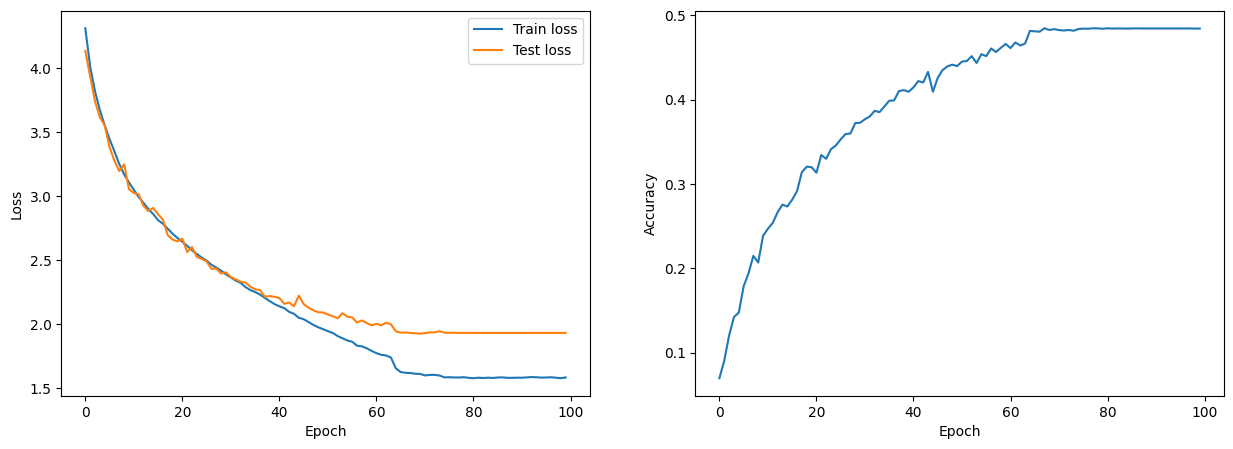

              precision    recall  f1-score   support

           0       0.55      0.85      0.67       100
           1       0.72      0.68      0.70       100
           2       0.46      0.40      0.43       100
           3       0.32      0.20      0.25       100
           4       0.32      0.19      0.24       100
           5       0.33      0.38      0.35       100
           6       0.66      0.61      0.64       100
           7       0.55      0.49      0.52       100
           8       0.50      0.57      0.54       100
           9       0.56      0.56      0.56       100
          10       0.28      0.25      0.27       100
          11       0.35      0.27      0.31       100
          12       0.59      0.56      0.57       100
          13       0.46      0.37      0.41       100
          14       0.40      0.29      0.34       100
          15       0.31      0.54      0.39       100
          16       0.57      0.43      0.49       100
          17       0.71    

In [113]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies, report = load_experiment(f"/kaggle/working/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()
print(report)